## **Exploring Modeling Techniques**

In this section, we explore different **machine learning models** to identify the best-performing approach for fraud detection.  
This comparison will guide the design of the final modeling pipeline.  

The models under consideration include:  
- **Logistic Regression**  
- **Support Vector Machine (SVM)**  
- **Random Forest**  
- **K-Nearest Neighbors (KNN)**  

By evaluating and comparing their performance, we aim to select the most effective model for integration into the pipeline.


In [1]:
 # Importing necessary libraries
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from sqlalchemy import create_engine
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import  confusion_matrix , precision_score , recall_score , f1_score, classification_report
from sklearn.model_selection import ParameterGrid
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as smtpipeline
from sklearn.pipeline import Pipeline as sklpipeline
from sklearn.compose import ColumnTransformer


In [2]:
load_dotenv()

 # Connecting to the database 
engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('user')}:{os.getenv('password')}@{os.getenv('host')}:{os.getenv('port')}/{os.getenv('database')}"
    )

In [3]:
 # importing the tables
try:
    DATA = pd.read_sql("SELECT * FROM transactions_train_raw", engine)
    print(" DATA SUCCESFULLY LOADED ")
except Exception as e:
        print(" ERROR : COULD NOT LOAD DATA FROM DATABASE : ", e)

 DATA SUCCESFULLY LOADED 


In [4]:
display(DATA)

,transaction_id,time_seconds,v1,v2,v3,v4,v5,v6,v7,v8,...,v22,v23,v24,v25,v26,v27,v28,ammount,fraud,timestamp
0,1,161919,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,...,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0,2025-09-21 20:58:39
1,2,124477,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,...,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0,2025-09-21 10:34:37
2,3,41191,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,...,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0,2025-09-20 11:26:31
3,4,132624,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,...,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0,2025-09-21 12:50:24
4,5,59359,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,...,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0,2025-09-20 16:29:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,227841,147710,1.993864,-0.516866,-0.620118,0.129845,-0.285128,0.395044,-0.822358,0.231591,...,0.884510,0.099141,0.275689,-0.195404,0.623598,-0.032455,-0.058552,5.99,0,2025-09-21 17:01:50
227841,227842,60764,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,...,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,36.99,0,2025-09-20 16:52:44
227842,227843,35301,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,...,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,45.42,0,2025-09-20 09:48:21
227843,227844,24413,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,...,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0.89,0,2025-09-20 06:46:53


We have succesfully loaded the Training dataset that has 227 rows and 33 columns 

In [5]:
 # Dividing the data into train and test data 
X = DATA.iloc[ :,2:-2 ]
y = DATA.iloc[ :,-2 ]

 # Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.690 total time=   1.6s
[CV 2/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.679 total time=   1.1s
[CV 3/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.820 total time=   1.2s
[CV 4/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.726 total time=   0.7s
[CV 5/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.800 total time=   1.1s
[CV 1/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.712 total time=   1.0s
[CV 2/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.679 total time=   0.9s
[CV 3/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.820 total time=   0.7s
[CV 4/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.726 total time=   0.7s
[CV 5/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.800 total time=   0.9s
[CV 1/5] END clf__C=

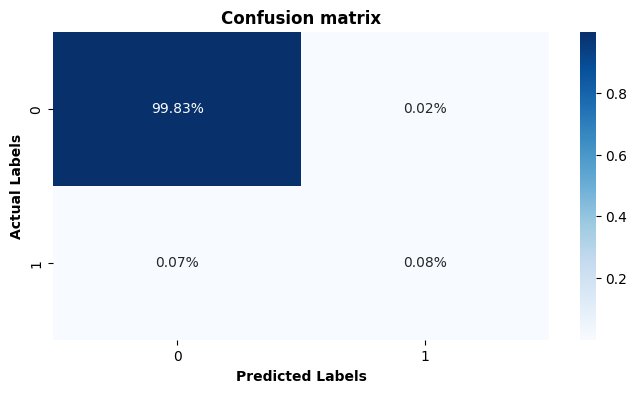

CLASSIFICATION REPOT
Best Parameters :  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV f1 score :  0.7504252020929343


,precision,recall,f1-score,support
0,0.999297,0.999824,0.999561,45501.000000
1,0.818182,0.529412,0.642857,68.000000
accuracy,0.999122,0.999122,0.999122,0.999122
macro avg,0.908739,0.764618,0.821209,45569.000000
weighted avg,0.999027,0.999122,0.999028,45569.000000


Precision:81.82%
Recall:52.94%
F1 Score:64.29%


In [6]:
 # Pipeline for modelling using logistic regression(without handling imbalance)
 # Scalling ammount column
scaled_col = ['ammount']

processor = ColumnTransformer(
    transformers = [
        ('scale_column', StandardScaler(), scaled_col )
    ],
    remainder = 'passthrough'
)

 # pipeline
pipe = sklpipeline([
    ('processor', processor),
    ('clf', LogisticRegression( max_iter=1000 ))
])

param_grid = [
    {'clf__penalty':[ 'l2'],
    'clf__C' : [0.1,1,10,100],
    'clf__solver': ['lbfgs']
}
]

 # cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = 'f1',
    cv = skf,
    n_jobs = 1,
    verbose = 3

)


grid.fit(X_train, y_train)

params_ = grid.best_params_

 # Evaluation
best_model1= grid.best_estimator_
y_pred1 = best_model1.predict(X_test)
y_pred1_prob = best_model1.predict_proba(X_test)[:,1]
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred1)
report = classification_report(y_test, y_pred1, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Heatmap for Confusion Matrix
plt.figure( figsize = ( 8 , 4 ) )

sns.heatmap( cm / np.sum( cm ) , annot=True, 
            fmt='.2%', cmap='Blues')

plt.title('Confusion matrix', fontweight='bold')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('Actual Labels', fontweight='bold')

plt.show()

print('CLASSIFICATION REPOT')
print('Best Parameters : ', params_)
print('Best CV f1 score : ', grid.best_score_)
display(report_df)
print("Precision:{:.2f}%".format(precision * 100))
print("Recall:{:.2f}%".format(recall* 100))
print("F1 Score:{:.2f}%".format(f1* 100))

### **Logistic Regression (Without Imbalance Handling)**

From the results of Logistic Regression without addressing class imbalance, we observe the following:  
- **Precision:** 81.82%  
- **Recall:** 52.94%  
- **F1-Score:** 64.28%  

**Interpretation:**  
- The model achieves high **precision** (81.82%), meaning that when it flags a transaction as fraudulent, it is correct most of the time.  
- However, the **recall** is relatively low (52.94%), indicating that the model misses nearly **47% of fraudulent transactions**.  
- The **F1-Score** balances precision and recall at 64.28%.  

This trade-off suggests that while the model is effective at minimizing **false alarms**, it may overlook a significant portion of fraud cases.  
In fraud detection, this approach could be acceptable in scenarios where **fewer false positives are preferred**, but further optimization is necessary to reduce missed frauds.


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.133 total time=  16.7s
[CV 2/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.115 total time=   7.2s
[CV 3/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.110 total time=   7.5s
[CV 4/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.108 total time=   6.7s
[CV 5/5] END clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs;, score=0.111 total time=   7.6s
[CV 1/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.133 total time=   6.4s
[CV 2/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.114 total time=   5.9s
[CV 3/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.110 total time=   8.2s
[CV 4/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.108 total time=  17.1s
[CV 5/5] END clf__C=1, clf__penalty=l2, clf__solver=lbfgs;, score=0.111 total time=  10.6s
[CV 1/5] END clf__C=

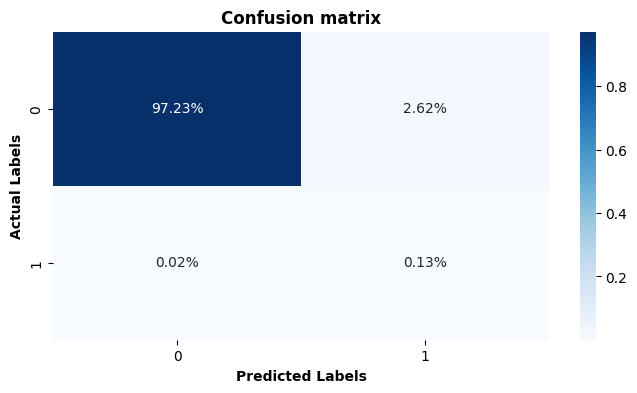

***CLASSIFICATION REPORT***
Best Parameters :  {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV f1 score :  0.11603485102230734


,precision,recall,f1-score,support
0,0.999797,0.973759,0.986606,45501.0000
1,0.047087,0.867647,0.089326,68.0000
accuracy,0.973600,0.973600,0.973600,0.9736
macro avg,0.523442,0.920703,0.537966,45569.0000
weighted avg,0.998375,0.973600,0.985267,45569.0000


Precision:4.71%
Recall:86.76%
F1 Score:8.93%


In [11]:
 # Pipeline for modelling using logistic regression(handling imbalance)
 # Scalling ammount column
scaled_col = ['ammount']

processor = ColumnTransformer(
    transformers = [
        ('scale_column', StandardScaler(), scaled_col )
    ],
    remainder = 'passthrough'
)

 # pipeline
smote_pipe = smtpipeline([
    ('processor', processor),
    ('smote', SMOTE(random_state = 42)),
    ('clf', LogisticRegression( max_iter=1000 ))
])

param_grid = [
    {'clf__penalty':['l2'],
    'clf__C' : [0.1,1,10,100],
    'clf__solver': ['lbfgs']
}
]

 # cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator = smote_pipe,
    param_grid = param_grid,
    scoring = 'f1',
    cv = skf,
    n_jobs = 1,
    verbose = 3

)

param_list = list(ParameterGrid(param_grid))

grid.fit(X_train, y_train)

 # Evaluation
best_model1= grid.best_estimator_
y_pred1 = best_model1.predict(X_test)
y_pred1_prob = best_model1.predict_proba(X_test)[:,1]
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred1)
report = classification_report(y_test, y_pred1, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Heatmap for Confusion Matrix
plt.figure( figsize = ( 8 , 4 ) )

sns.heatmap( cm / np.sum( cm ) , annot=True, 
            fmt='.2%', cmap='Blues')

plt.title('Confusion matrix', fontweight='bold')
plt.xlabel('Predicted Labels', fontweight='bold')
plt.ylabel('Actual Labels', fontweight='bold')

plt.show()

print('***CLASSIFICATION REPORT***')
print('Best Parameters : ', grid.best_params_)
print('Best CV f1 score : ', grid.best_score_)
display(report_df)
print("Precision:{:.2f}%".format(precision * 100))
print("Recall:{:.2f}%".format(recall* 100))
print("F1 Score:{:.2f}%".format(f1* 100))



### **Logistic Regression (With Imbalance Handling)**

From the results of Logistic Regression while handling class imbalance, we observe the following:  
- **Precision:** 4.72%  
- **Recall:** 86.76%  
- **F1-Score:** 8.95%  

**Interpretation:**  
- The model achieves very high **recall** (86.76%), meaning it successfully detects the majority of fraudulent transactions.  
- However, the **precision** is extremely low (4.72%), indicating that most transactions flagged as fraudulent are actually not fraudulent (a large number of false positives).  
- The resulting **F1-Score** of 8.95% reflects this imbalance between precision and recall.  

This suggests that when using Logistic Regression, **handling class imbalance reduces overall effectiveness**:  
- Without imbalance handling → higher precision and better balance between metrics.  
- With imbalance handling → very high recall but poor precision, leading to many false alarms.  

**Conclusion:** For Logistic Regression, it is preferable **not to apply imbalance handling**, as the model performs better in terms of practical fraud detection trade-offs.

### **Logistic Regression Performance Comparison**

| Model Variation               | Precision | Recall  | F1-Score |
|--------------------------------|-----------|---------|----------|
| **Without Imbalance Handling** | **81.82%** | 52.94% | **64.28%** |
| **With Imbalance Handling**    | 4.72%    | **86.76%** | 8.95%   |

**Key Insight:**  
- **Without imbalance handling** → Better precision and a balanced F1-score, fewer false positives.  
- **With imbalance handling** → Higher recall but very poor precision, leading to excessive false alarms.  

👉 For Logistic Regression, **not handling imbalance yields better overall performance**.


### **Model Selection Decision**

Due to computational constraints and the intensive nature of training models such as **SVM**, **KNN**, and **Random Forest**,  
we decided to proceed with **Logistic Regression** as the primary model.  

This choice ensures:  
- **Efficiency** → Logistic Regression is lightweight and less computationally demanding.  
- **Interpretability** → It provides clear insights into the relationship between features and fraud detection.  
- **Practicality** → Despite not being the most complex model, it offers a good balance between performance and resource usage.  

Therefore, Logistic Regression will serve as the **final modeling approach** in this project, forming the basis of the fraud detection pipeline.  

**Future Work:**  
When computational resources allow, we may extend the modeling to include more complex algorithms  
such as Random Forest, Gradient Boosting, or Neural Networks to evaluate potential performance improvements.


In [10]:
import mlflow
from mlflow.models import infer_signature

In [11]:
mlflow.set_tracking_uri( os.getenv('tracking_uri') )

mlflow.set_experiment("Fraud_Detection_Pipeline_test1")

2025/10/05 13:45:46 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_Pipeline_test1' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:C:/PYTHON_PROJECTS/Scripts/Fraud Detection Pipeline/mlflow_artifact/1', creation_time=1759661146907, experiment_id='1', last_update_time=1759661146907, lifecycle_stage='active', name='Fraud_Detection_Pipeline_test1', tags={}>

In [12]:
with mlflow.start_run():
    mlflow.log_params(params_)
    mlflow.log_metric("Precision", precision )
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1_Score", f1)

    signature = infer_signature(X_train, best_model1.predict(X_train))

    model_info = mlflow.sklearn.log_model(
        sk_model = best_model1,
        name = "Fraud Detection Model",
        signature = signature,
        input_example = X_train,
        registered_model_name = "George Test"
    )
    
    mlflow.set_logged_model_tags(
        model_info.model_id,{
            "Training info" : "Fraud model"
        }
    )


Successfully registered model 'George Test'.
2025/10/05 13:47:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: George Test, version 1
Created version '1' of model 'George Test'.


🏃 View run bald-trout-693 at: http://127.0.0.1:5000/#/experiments/1/runs/80302a4cd3324e97806d5fe26bddbfea
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------
# 🔧 Configure MLflow Connection
# ------------------------------
mlflow.set_tracking_uri( os.getenv('tracking_uri') )
mlflow.set_experiment("Fraud_Detection_Pipeline_test_2")

# ------------------------------
# ⚙️ Log Model Training Details
# ------------------------------
with mlflow.start_run() as run:
    # Example parameter dictionary
    mlflow.log_params(params_)

    # Example metrics
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1_Score", f1)

    # --------------------------
    #  Log Model Artifact
    # --------------------------
    signature = infer_signature(X_train, best_model1.predict(X_train))

    mlflow.sklearn.log_model(
        sk_model=best_model1,
        artifact_path="model",
        signature=signature,
        input_example=X_train,
    )

    # --------------------------
    # Confusion Matrix Plot
    # --------------------------
    y_pred = best_model1.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.close()

    mlflow.log_artifact("confusion_matrix.png")

    # --------------------------
    # Classification Report
    # --------------------------
    report = classification_report(y_test, y_pred, target_names=["No Fraud", "Fraud"])

    with open("classification_report.txt", "w") as f:
        f.write(report)

    mlflow.log_artifact("classification_report.txt")

    # --------------------------
    #  Log Data Samples
    # --------------------------
    sample_df = pd.DataFrame(X_test[:5])
    sample_df["predicted_label"] = y_pred[:5]
    sample_df.to_csv("sample_predictions.csv", index=False)
    mlflow.log_artifact("sample_predictions.csv")



2025/10/05 13:54:46 INFO mlflow.tracking.fluent: Experiment with name 'Fraud_Detection_Pipeline_test_2' does not exist. Creating a new experiment.
2025/10/05 13:55:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run marvelous-bear-849 at: http://127.0.0.1:5000/#/experiments/2/runs/bd22f0e5f53f4291bf68bdd73e160846
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
